**Predictive Maintenance using LSTM**

Created on 30 July 2019 for Dish IOT demo

Regression models: How many more cycles an in-service device will last before it fails?

***References:***
https://github.com/Azure/lstms_for_predictive_maintenance/blob/master/Deep%20Learning%20Basics%20for%20Predictive%20Maintenance.ipynb
https://gallery.cortanaintelligence.com/Experiment/Predictive-Maintenance-Step-2A-of-3-train-and-evaluate-regression-models-2
https://ti.arc.nasa.gov/tech/dash/pcoe/prognostic-data-repository/#turbofan

Regression models: How many more cycles an in-service device will last before it fails?

https://github.com/umbertogriffo/Predictive-Maintenance-using-LSTM


In [1]:
import pandas as pd
import numpy as np
import matplotlib
# matplotlib.use("Agg")
import matplotlib.pyplot as plt
import os
from sklearn import preprocessing
# Setting seed for reproducibility - do this before importing keras.models.Sequential
np.random.seed(20190801)
PYTHONHASHSEED = 8012019
# Setting seed for reproducibility
np.random.seed(1234)  
PYTHONHASHSEED = 0

import keras
import keras.backend as K
from keras.layers.core import Activation
from keras.models import Sequential,load_model
from keras.layers import Dense, Dropout, LSTM

# define path to save model
model_path = '../Output/regression_model.h5'


Using TensorFlow backend.


In [2]:
##################################
# Data Ingestion
##################################

df = pd.read_csv('../Dataset/predict-transform-output.csv')
df.columns = ['unit_number', 'device_timestamp', 'latency', 'voltage', 'availBw', 'vlanId', 'erroredSeconds',
                     'cpu', 'unique_sequence', 'rul']
df = df.sort_values(['unit_number','unique_sequence'])


In [3]:
# read test data - It is the aircraft engine operating data without failure events recorded.
# test_df = pd.read_csv('../Dataset/predict-transform-output.csv')
# test_df = pd.read_csv('../Dataset/device data for testing.csv')

# test_df.columns = ['unit_number', 'unique_sequence', 'latency', 'voltage', 'availBw', 'vlanId', 'erroredSeconds',
#                      'cpu', 'rul']

In [4]:
from sklearn.model_selection import KFold
k = 5
kf = KFold(n_splits=k, random_state=201809, shuffle=True)
unit_number = df.unit_number.unique()
kf.get_n_splits(unit_number)

fold_indices = []
for train_indices, test_indices in kf.split(unit_number):
    fold_indices.append((train_indices, test_indices))

In [5]:
# just build for one fold first; then we can put in a loop
train_ids = unit_number[fold_indices[0][0]]
test_ids = unit_number[fold_indices[0][1]]

train_df = df[df['unit_number'].isin(train_ids)]
test_df = df[df['unit_number'].isin(test_ids)]

train_df = train_df.sort_values(['unit_number', 'unique_sequence'])
test_df = test_df.sort_values(['unit_number', 'unique_sequence'])

In [6]:
print(train_df.shape)

# Lets check number of unique devices
print(len(train_df['unit_number'].unique()))
print(train_df['unit_number'].unique())
train_df.head()

(20149, 10)
80
[ 1  2  3  5  6  8  9 10 11 12 13 14 15 16 17 18 20 21 22 23 24 25 27 28
 29 30 31 33 34 35 36 37 38 40 41 43 44 46 47 48 50 51 52 53 54 55 56 57
 58 59 60 61 62 63 64 65 66 67 69 70 71 73 74 75 77 78 79 82 84 85 86 90
 91 93 94 95 96 97 98 99]


,unit_number,device_timestamp,latency,voltage,availBw,vlanId,erroredSeconds,cpu,unique_sequence,rul
0,1,1564349324,261,13.48,85,101,23,29,1,258
1,1,1564349325,259,13.53,87,101,21,73,2,257
2,1,1564349326,258,22.03,79,101,50,58,3,256
3,1,1564349327,259,9.03,89,102,31,36,4,255
4,1,1564349328,256,14.27,91,101,70,44,5,254


In [7]:
print(test_df.shape)
# Lets check number of unique devices
print(len(test_df['unit_number'].unique()))
print(test_df['unit_number'].unique())
test_df.head()

(4571, 10)
20
[  4   7  19  26  32  39  42  45  49  68  72  76  80  81  83  87  88  89
  92 100]


,unit_number,device_timestamp,latency,voltage,availBw,vlanId,erroredSeconds,cpu,unique_sequence,rul
734,4,1564349324,262,24.58,79,101,53,65,1,271
735,4,1564349325,264,22.49,81,102,45,31,2,270
736,4,1564349326,269,21.64,72,102,67,65,3,269
737,4,1564349327,275,20.63,96,101,70,54,4,268
738,4,1564349328,262,19.26,86,100,50,51,5,267


In [8]:
##################################
# Data Preprocessing
##################################

#######
# TRAIN
#######

# generate label columns for training data
# we will only make use of "label1" for binary classification, 
# while trying to answer the question: is a specific engine going to fail within w1 cycles?
w1 = 30
w0 = 15
train_df['label1'] = np.where(train_df['rul'] <= w1, 1, 0 )
train_df['label2'] = train_df['label1']
train_df.loc[train_df['rul'] <= w0, 'label2'] = 2
train_df.head()

,unit_number,device_timestamp,latency,voltage,availBw,vlanId,erroredSeconds,cpu,unique_sequence,rul,label1,label2
0,1,1564349324,261,13.48,85,101,23,29,1,258,0,0
1,1,1564349325,259,13.53,87,101,21,73,2,257,0,0
2,1,1564349326,258,22.03,79,101,50,58,3,256,0,0
3,1,1564349327,259,9.03,89,102,31,36,4,255,0,0
4,1,1564349328,256,14.27,91,101,70,44,5,254,0,0


In [9]:
# generate label columns w0 and w1 for test data
test_df['label1'] = np.where(test_df['rul'] <= w1, 1, 0 )
test_df['label2'] = test_df['label1']
test_df.loc[test_df['rul'] <= w0, 'label2'] = 2

In [10]:
# MinMax normalization (from 0 to 1)
train_df['unique_sequence_norm'] = train_df['unique_sequence']
cols_normalize = train_df.columns.difference(['unit_number', 'device_timestamp', 'unique_sequence', 'rul','label1','label2'])

min_max_scaler = preprocessing.MinMaxScaler()
norm_train_df = pd.DataFrame(min_max_scaler.fit_transform(train_df[cols_normalize]), 
                             columns=cols_normalize, 
                             index=train_df.index)
join_df = train_df[train_df.columns.difference(cols_normalize)].join(norm_train_df)
train_df = join_df.reindex(columns = train_df.columns)
train_df.head()

,unit_number,device_timestamp,latency,voltage,availBw,vlanId,erroredSeconds,cpu,unique_sequence,rul,label1,label2,unique_sequence_norm
0,1,1564349324,0.22,0.188444,0.800000,0.2,0.222222,0.282828,1,258,0,0,0.000000
1,1,1564349325,0.18,0.189556,0.826667,0.2,0.202020,0.727273,2,257,0,0,0.001908
2,1,1564349326,0.16,0.378444,0.720000,0.2,0.494949,0.575758,3,256,0,0,0.003817
3,1,1564349327,0.18,0.089556,0.853333,0.4,0.303030,0.353535,4,255,0,0,0.005725
4,1,1564349328,0.12,0.206000,0.880000,0.2,0.696970,0.434343,5,254,0,0,0.007634


In [11]:
cols_normalize

Index(['availBw', 'cpu', 'erroredSeconds', 'latency', 'unique_sequence_norm',
       'vlanId', 'voltage'],
      dtype='object')

In [12]:
######
# TEST
######
# MinMax normalization (from 0 to 1)
test_df['unique_sequence_norm'] = test_df['unique_sequence']
norm_test_df = pd.DataFrame(min_max_scaler.transform(test_df[cols_normalize]), 
                            columns=cols_normalize, 
                            index=test_df.index)
test_join_df = test_df[test_df.columns.difference(cols_normalize)].join(norm_test_df)
test_df = test_join_df.reindex(columns = test_df.columns)
test_df = test_df.reset_index(drop=True)
test_df.head()

,unit_number,device_timestamp,latency,voltage,availBw,vlanId,erroredSeconds,cpu,unique_sequence,rul,label1,label2,unique_sequence_norm
0,4,1564349324,0.24,0.435111,0.720000,0.2,0.525253,0.646465,1,271,0,0,0.000000
1,4,1564349325,0.28,0.388667,0.746667,0.4,0.444444,0.303030,2,270,0,0,0.001908
2,4,1564349326,0.38,0.369778,0.626667,0.4,0.666667,0.646465,3,269,0,0,0.003817
3,4,1564349327,0.50,0.347333,0.946667,0.2,0.696970,0.535354,4,268,0,0,0.005725
4,4,1564349328,0.24,0.316889,0.813333,0.0,0.494949,0.505051,5,267,0,0,0.007634


In [13]:
# pick a large window size of 50 cycles
sequence_length = 100

# function to reshape features into (samples, time steps, features) 
def gen_sequence(id_df, seq_length, seq_cols):
    """ Only sequences that meet the window-length are considered, no padding is used. This means for testing
    we need to drop those which are below the window-length. An alternative would be to pad sequences so that
    we can use shorter ones """
    # for one id I put all the rows in a single matrix
    data_matrix = id_df[seq_cols].values
    num_elements = data_matrix.shape[0]
    # Iterate over two lists in parallel.
    # For example id1 have 192 rows and sequence_length is equal to 50
    # so zip iterate over two following list of numbers (0,112),(50,192)
    # 0 50 -> from row 0 to row 50
    # 1 51 -> from row 1 to row 51
    # 2 52 -> from row 2 to row 52
    # ...
    # 111 191 -> from row 111 to 191
    for start, stop in zip(range(0, num_elements-seq_length), range(seq_length, num_elements)):
        yield data_matrix[start:stop, :]

In [14]:
# pick the feature columns 
sequence_cols = ['latency', 'voltage', 'availBw', 'vlanId', 'erroredSeconds', 'cpu', 'unique_sequence_norm']
sequence_cols

['latency',
 'voltage',
 'availBw',
 'vlanId',
 'erroredSeconds',
 'cpu',
 'unique_sequence_norm']

In [15]:
# generator for the sequences
# transform each id of the train dataset in a sequence
seq_gen = (list(gen_sequence(train_df[train_df['unit_number']==id], sequence_length, sequence_cols)) 
           for id in train_df['unit_number'].unique())

# generate sequences and convert to numpy array
seq_array = np.concatenate(list(seq_gen)).astype(np.float32)
print(seq_array.shape)

(12149, 100, 7)


In [16]:
# function to generate labels
def gen_labels(id_df, seq_length, label):
    """ Only sequences that meet the window-length are considered, no padding is used. This means for testing
    we need to drop those which are below the window-length. An alternative would be to pad sequences so that
    we can use shorter ones """
    # For one id I put all the labels in a single matrix.
    # For example:
    # [[1]
    # [4]
    # [1]
    # [5]
    # [9]
    # ...
    # [200]] 
    data_matrix = id_df[label].values
    num_elements = data_matrix.shape[0]
    # I have to remove the first seq_length labels
    # because for one id the first sequence of seq_length size have as target
    # the last label (the previus ones are discarded).
    # All the next id's sequences will have associated step by step one label as target.
    return data_matrix[seq_length:num_elements, :]

# generate labels
label_gen = [gen_labels(train_df[train_df['unit_number']==id], sequence_length, ['rul']) 
             for id in train_df['unit_number'].unique()]

label_array = np.concatenate(label_gen).astype(np.float32)
label_array.shape

(12149, 1)

In [17]:
# generator for the sequences in test set
# transform each id of the test dataset in a sequence
seq_gen_test = (list(gen_sequence(test_df[test_df['unit_number']==id], sequence_length, sequence_cols)) 
           for id in test_df['unit_number'].unique())

# generate sequences and convert to numpy array
seq_array_test = np.concatenate(list(seq_gen_test)).astype(np.float32)
print(seq_array_test.shape)
# generate labels
label_gen_test = [gen_labels(test_df[test_df['unit_number']==id], sequence_length, ['rul']) 
             for id in test_df['unit_number'].unique()]

label_array_test = np.concatenate(label_gen_test).astype(np.float32)
print(label_array_test.shape)

(2571, 100, 7)
(2571, 1)


In [18]:
##################################
# Modeling
##################################

def r2_keras(y_true, y_pred):
    """Coefficient of Determination 
    """
    SS_res =  K.sum(K.square( y_true - y_pred ))
    SS_tot = K.sum(K.square( y_true - K.mean(y_true) ) )
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

# Next, we build a deep network. 
# The first layer is an LSTM layer with 100 units followed by another LSTM layer with 50 units. 
# Dropout is also applied after each LSTM layer to control overfitting. 
# Final layer is a Dense output layer with single unit and linear activation since this is a regression problem.
nb_features = seq_array.shape[2]
nb_out = label_array.shape[1]

model = Sequential()
model.add(LSTM(
         input_shape=(sequence_length, nb_features),
         units=100,
         return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(
          units=50,
          return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(units=nb_out))
model.add(Activation("linear"))
model.compile(loss='mean_squared_error', optimizer='rmsprop',metrics=['mae',r2_keras])

print(model.summary())

# fit the network
# history = model.fit(seq_array, label_array, epochs=100, batch_size=100, validation_split=0.1, verbose=2,
#           callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=0, mode='min'),
#                        keras.callbacks.ModelCheckpoint(model_path,monitor='val_loss', save_best_only=True, mode='min', verbose=0)]
#           )

history = model.fit(seq_array, label_array, epochs=100, batch_size=100, validation_split=0.1, verbose=2,
          callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=0, mode='min')]
          )

# history = model.fit(seq_array, label_array, epochs=100, batch_size=100, validation_data=(seq_array_test, label_array_test), verbose=2,
#           callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=0, mode='min')]
#           )

# list all data in history
print(history.history.keys())

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 100, 100)          43200     
_________________________________________________________________
dropout_1 (Dropout)          (None, 100, 100)          0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 50)                30200     
_________________________________________________________________
dropout_2 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 51        
_________________________________________________________________
activation_1 (Activat

Epoch 36/100
 - 55s - loss: 1395.9899 - mean_absolute_error: 19.2956 - r2_keras: 0.8031 - val_loss: 2924.7561 - val_mean_absolute_error: 30.4914 - val_r2_keras: -1.7168e+00
Epoch 37/100
 - 54s - loss: 1323.3382 - mean_absolute_error: 19.0402 - r2_keras: 0.8133 - val_loss: 2607.3172 - val_mean_absolute_error: 27.7707 - val_r2_keras: -1.4063e+00
Epoch 38/100
 - 54s - loss: 1240.7887 - mean_absolute_error: 18.5805 - r2_keras: 0.8247 - val_loss: 2169.6212 - val_mean_absolute_error: 25.4699 - val_r2_keras: -1.2162e+00
Epoch 39/100
 - 53s - loss: 1166.0612 - mean_absolute_error: 18.0425 - r2_keras: 0.8342 - val_loss: 1997.6183 - val_mean_absolute_error: 23.2979 - val_r2_keras: -1.0077e+00
Epoch 40/100
 - 58s - loss: 1114.2423 - mean_absolute_error: 17.5897 - r2_keras: 0.8415 - val_loss: 1855.5610 - val_mean_absolute_error: 23.2959 - val_r2_keras: -8.8505e-01
Epoch 41/100
 - 54s - loss: 1042.9952 - mean_absolute_error: 17.1955 - r2_keras: 0.8514 - val_loss: 2023.2880 - val_mean_absolute_error

In [19]:
# define path to save model
model_path = '../Output/rul_model.h5'
model.save(model_path)

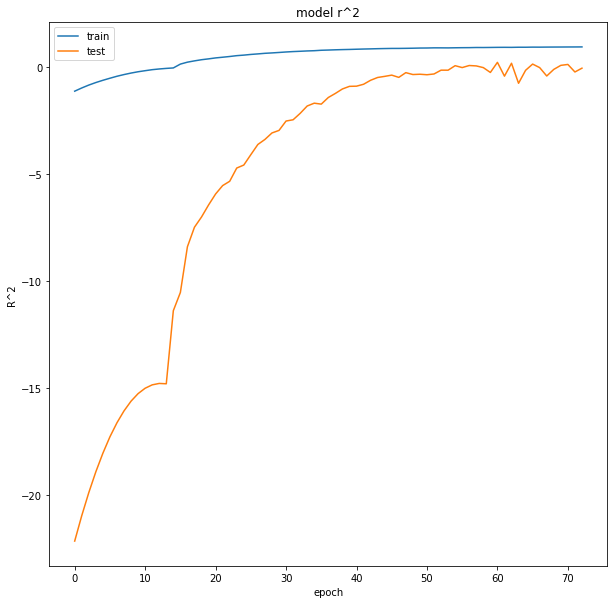

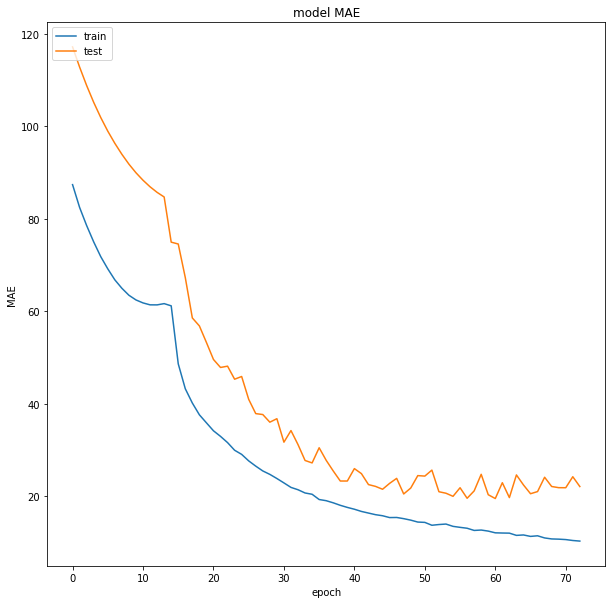

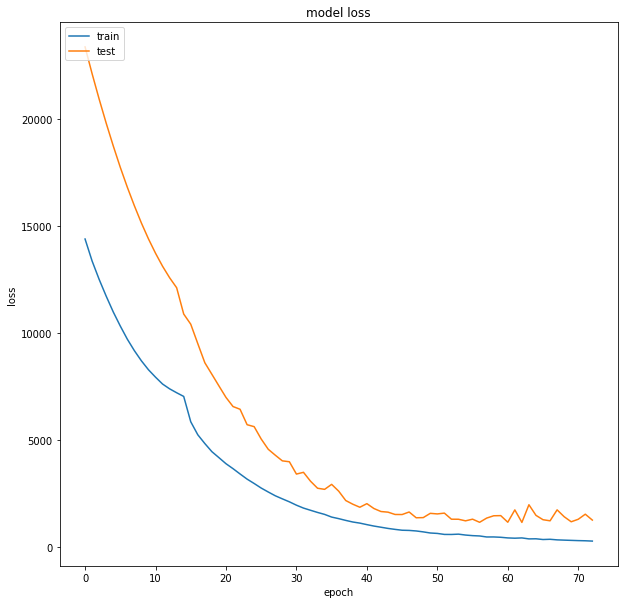

In [20]:
# summarize history for R^2
fig_acc = plt.figure(figsize=(10, 10))
plt.plot(history.history['r2_keras'])
plt.plot(history.history['val_r2_keras'])
plt.title('model r^2')
plt.ylabel('R^2')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
# plt.show()
fig_acc.savefig("../Output/model_r2.png")

# summarize history for MAE
fig_acc = plt.figure(figsize=(10, 10))
plt.plot(history.history['mean_absolute_error'])
plt.plot(history.history['val_mean_absolute_error'])
plt.title('model MAE')
plt.ylabel('MAE')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
# plt.show()
fig_acc.savefig("../Output/model_mae.png")


# summarize history for Loss
fig_acc = plt.figure(figsize=(10, 10))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
fig_acc.savefig("../Output/model_regression_loss.png")


In [25]:
# training metrics
train_scores = model.evaluate(seq_array, label_array, verbose=1, batch_size=200)
print('\nMAE: {}'.format(train_scores[1]))
print('\nR^2: {}'.format(train_scores[2]))

12149/12149 [==============================] - 13s 1ms/step

MAE: 10.61280471066387

R^2: 0.9050428794582093


In [26]:
# testing metrics
test_scores = model.evaluate(seq_array_test, label_array_test, verbose=1, batch_size=200)
print('\nMAE: {}'.format(test_scores[1]))
print('\nR^2: {}'.format(test_scores[2]))

2571/2571 [==============================] - 3s 1ms/step

MAE: 11.544728576603774

R^2: 0.8665896885268005
